In [1]:
%matplotlib inline
from datavyz import ge
import numpy as np

In [2]:
import sys, os
sys.path.append('../')
from data.Import import LoadPairData

dataC = LoadPairData(5, condition='Control')
dataT = LoadPairData(3, condition='ZX1')

In [3]:
dataC.keys()

dict_keys(['recordings', 'stimulations', 'filename', 't', 'window'])

In [33]:
def normalize_trace(data,
                    with_peak_normalization=False,
                    start=100, bsl_time = 2, window_for_peak=[100,140]):
    zoom = data['window']
    cond = (data['t']>zoom[0]) & (data['t']<zoom[1])
    baseline_cond = (data['t']>zoom[0]+start-bsl_time) & (data['t']<zoom[0]+start)
    irk = 'Irecording'
    mean = data['recordings'][irk][:,baseline_cond].mean()
    Itrace = data['recordings'][irk].mean(axis=0)[cond]-mean
    peak_cond = (data['t'][cond]>=window_for_peak[0]+zoom[0]) & (data['t'][cond]<=window_for_peak[1]+zoom[0])
    if with_peak_normalization:
        peak = np.max(Itrace[peak_cond])
    else:
        peak=1
    return 1e3*peak, Itrace/peak

def pair_recording_plot_comparison(icell=0,
                                   with_peak_normalization=False,
                                   start=100, bsl_time = 10, window_for_peak=[100,140]):
    
    
    dataC = LoadPairData(icell, condition='Control')
    dataT = LoadPairData(icell, condition='ZX1')
    zoom = dataC['window']
    
    # fig
    fig, AX = ge.figure(axes=(1,3), figsize=(3,3), hspace=0.1)
    cond = (dataC['t']>zoom[0]) & (dataC['t']<zoom[1])
    AX[1].set_title(os.path.basename(dataC['filename']))#+'-----'+dataT['filename'])
    
    # free-Zinc case
    irk, vrk = 'Irecording', 'Vrecording'
    plot_cond = (dataC['stimulations']['ICommand'][cond]<=0) # blanking artefact
    peak, norm_Trace = normalize_trace(dataC, bsl_time=bsl_time,
                                       with_peak_normalization=with_peak_normalization,
                                       window_for_peak=window_for_peak)
    AX[0].plot(dataC['t'][cond][plot_cond], norm_Trace[plot_cond], color='k')
    AX[1].plot(dataC['t'][cond], 1e3*dataC['recordings'][irk].mean(axis=0)[cond], color='k')
    AX[2].plot(dataC['t'][cond], dataC['recordings'][vrk].mean(axis=0)[cond], label='free-Zinc', color='k')
    if with_peak_normalization:
        ge.annotate(AX[0], '%.1fpA' % peak, (zoom[0]+.8*bsl_time,.5),
                color='k', ha='right', xycoords='data', rotation=90 ,size='large')
        
    # integral free zinc
    integral_condition = (dataC['t'][cond]>zoom[0]+start) & (dataC['t'][cond]<zoom[0]+start+250)
    freeZn_integral = np.trapz(norm_Trace[integral_condition])
    
    # chelated-Zinc case
    plot_cond = (dataT['stimulations']['ICommand'][cond]<=0) # blanking artefact
    peak, norm_Trace = normalize_trace(dataT,
                                       with_peak_normalization=with_peak_normalization,
                                       bsl_time=bsl_time, window_for_peak=window_for_peak)
    AX[0].plot(dataT['t'][cond][plot_cond], norm_Trace[plot_cond], color=ge.green)
    AX[1].plot(dataT['t'][cond], 1e3*dataT['recordings'][irk].mean(axis=0)[cond], color=ge.green)
    AX[2].plot(dataT['t'][cond], dataT['recordings'][vrk].mean(axis=0)[cond], color=ge.green, label='chelated-Zinc')
    AX[2].legend()
    if with_peak_normalization:
        AX[0].plot(zoom[0]+.8*bsl_time+np.zeros(2), [.5,1.], 'k-', lw=1)
        ge.annotate(AX[0], '%.1fpA\n' % (peak/2.), (zoom[0]+.8*bsl_time,.5),
                color=ge.green, ha='right', xycoords='data', rotation=90 ,size='large')
    ge.set_plot(AX[0], ['left'], ylabel='norm. I \n (+low-pass+artefact-blank)', xlim=zoom)
    ge.set_plot(AX[1], ['left'], ylabel='raw I (pA)', xlim=zoom)
    ge.set_plot(AX[2], ylabel='pre Vm (mV)', xlabel='time (ms)', xlim=zoom)
    
    # integral chelated zinc
    #integral_condition = (dataT['t'][cond]>zoom[0]+start+50) & (dataT['t'][cond]<zoom[0]+start+250)
    chelatedZn_integral = np.trapz(norm_Trace[integral_condition])
    
    return chelatedZn_integral, freeZn_integral
    
def pair_recording_plot(data):
    zoom = data['window']
    fig, AX = ge.figure(axes=(1,2), figsize=(3,3), hspace=0.1)
    cond = (data['t']>zoom[0]) & (data['t']<zoom[1])
    irk, vrk = 'Irecording', 'Vrecording'
    AX[0].plot(data['t'][cond], data['recordings'][irk].mean(axis=0)[cond])
    AX[1].plot(data['t'][cond], data['recordings'][vrk].mean(axis=0)[cond])
    ge.title(AX[0], os.path.basename(data['filename']))

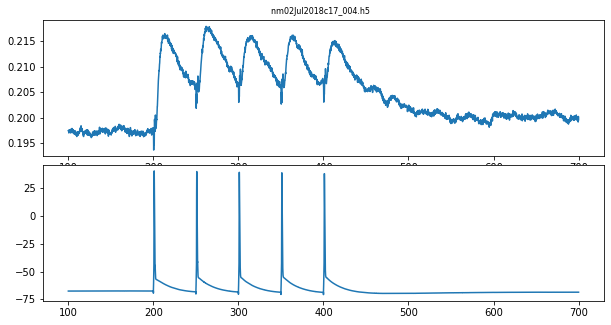

In [34]:
data = LoadPairData(1, condition='ZX1')
pair_recording_plot(data)

(276.2243801989887, 123.52625653440494)


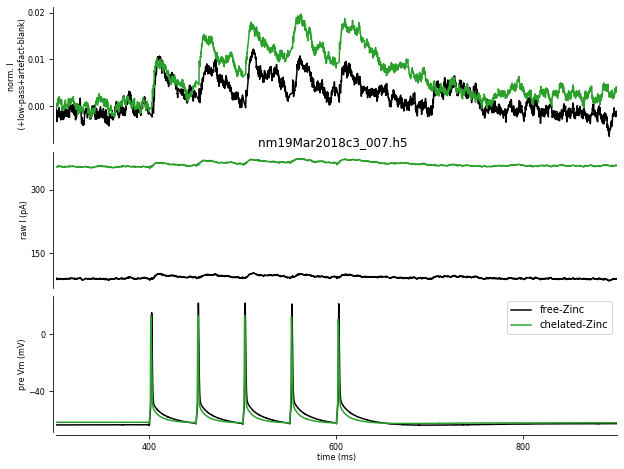

In [35]:
print(pair_recording_plot_comparison(icell=6, with_peak_normalization=False))

/media/yann/DATADRIVE1/DATA/Data_Nunzio/2019/July/nm18Jul2019c0/nm18Jul2019c0_002.h5    limited to 34 sweeps


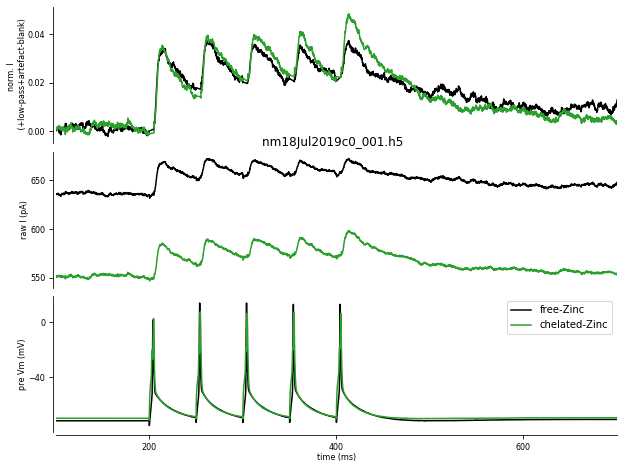

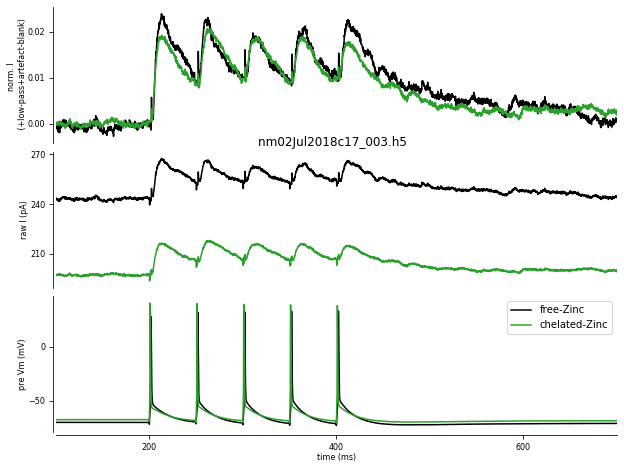

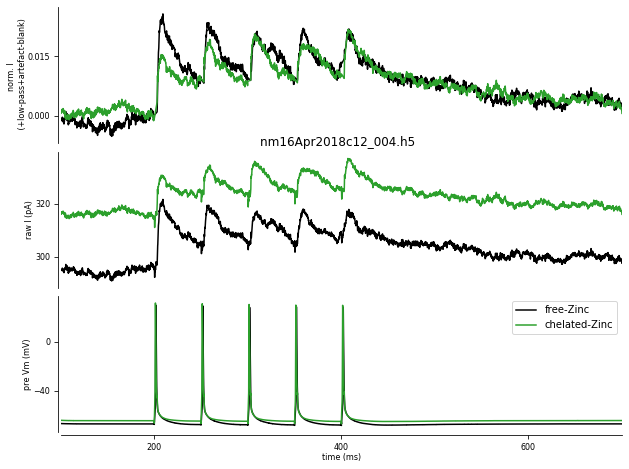

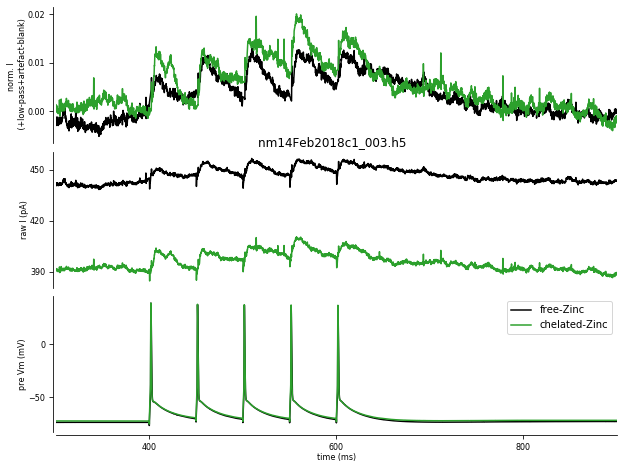

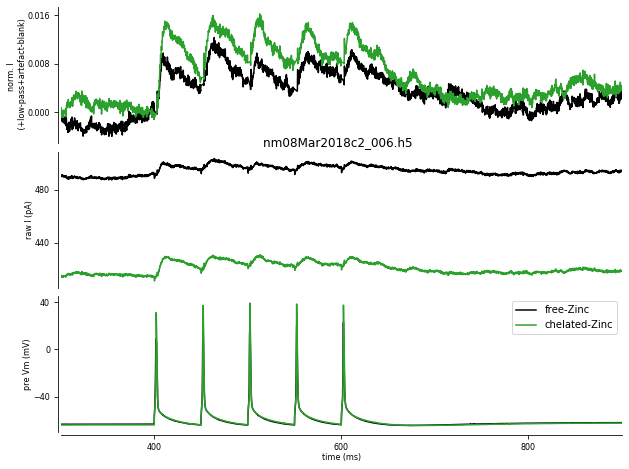

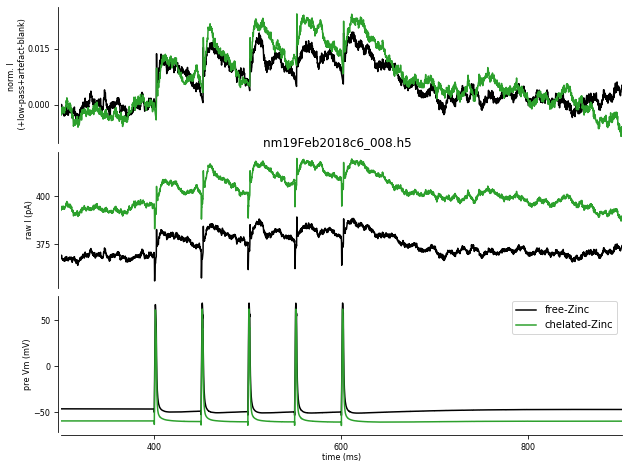

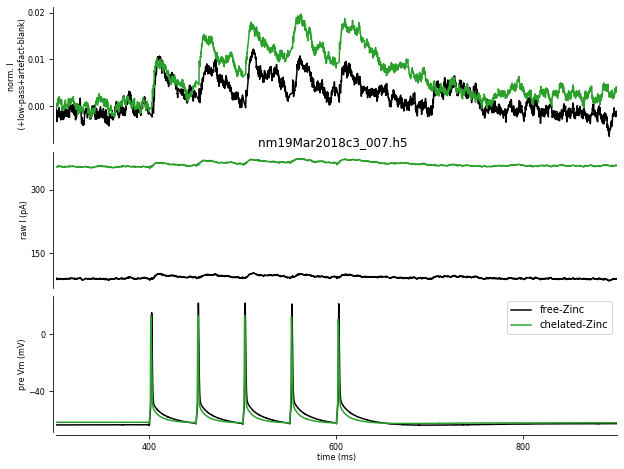

In [36]:
from data.exp_datasets import L23L23_PAIRS_DATASET
IntegralChelated, IntegralFree = [], []
for i in range(len(L23L23_PAIRS_DATASET)):
    chel, free = pair_recording_plot_comparison(icell=i, with_peak_normalization=True)
    IntegralChelated.append(chel)
    IntegralFree.append(free)

In [37]:
for x1, x2, d in zip(IntegralChelated, IntegralFree, L23L23_PAIRS_DATASET):
    print(d['Control'][0], '---', x1, x2)

nm18Jul2019c0_001.h5 --- 709.2837816009655 649.9359052599087
nm02Jul2018c17_003.h5 --- 336.28000159199553 367.93038622158326
nm16Apr2018c12_004.h5 --- 314.061937227699 359.3308310583023
nm14Feb2018c1_003.h5 --- 245.58444545636135 172.24155067992206
nm08Mar2018c2_006.h5 --- 262.305588122047 165.0986974998753
nm19Feb2018c6_007.h5 --- 361.19972245792553 283.1108302230898
nm19Mar2018c3_006.h5 --- 276.2243801989887 123.52625653440494


(<Figure size 119.055x306.142 with 1 Axes>,
 0.08517561590700604)

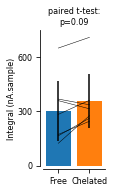

In [38]:
ge.related_samples_two_conditions_comparison(IntegralFree, IntegralChelated, 
                                             fig_args=dict(figsize=(1,3)),
                                             ylabel='Integral (nA.sample)',
                                             xticks_labels=['Free', 'Chelated'])

/media/yann/DATADRIVE1/DATA/Data_Nunzio/2019/July/nm18Jul2019c0/nm18Jul2019c0_002.h5    limited to 34 sweeps


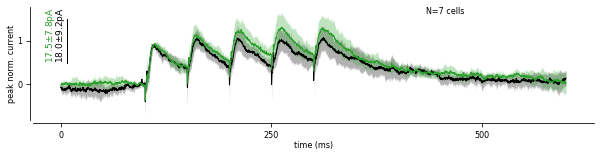

In [32]:
def pair_recording_summary_comparison(zoom=[0, 500],
                                      with_peak_normalization=False,
                                      bsl_time = 10, window_for_peak=[100,140]):

    FreeZinc, ChelatedZinc =[], []
    FreeZinc_peaks, ChelatedZinc_peaks =[], []
    
    for icell in range(len(L23L23_PAIRS_DATASET)):

        dataC = LoadPairData(icell, condition='Control')
        zoom=dataC['window']
        cond = (dataC['t']>zoom[0]) & (dataC['t']<zoom[1])
        #plot_cond = (dataC['stimulations'][dataC['Icmd_key']][cond]<=0) # blanking artefact
        peak, norm_Trace = normalize_trace(dataC,
                                           with_peak_normalization=with_peak_normalization,
                                           bsl_time=bsl_time, window_for_peak=window_for_peak)
        FreeZinc.append(norm_Trace)
        FreeZinc_peaks.append(peak)

        dataT = LoadPairData(icell, condition='ZX1')        
        peak, norm_Trace = normalize_trace(dataT,
                                                with_peak_normalization=with_peak_normalization,
                                             bsl_time=bsl_time, window_for_peak=window_for_peak)
        ChelatedZinc.append(norm_Trace)
        ChelatedZinc_peaks.append(peak)
        
    t = dataT['t'][cond]#[plot_cond]
    fig, ax = ge.figure(figsize=(3,2.5))
    
    if with_peak_normalization:
        ax.plot(.8*bsl_time+np.zeros(2), [.5,1.5], 'k-', lw=1)
        ge.annotate(ax, '%.1f$\pm$%.1fpA' % (np.mean(FreeZinc_peaks),np.std(FreeZinc_peaks)),
                (.8*bsl_time,.5), color='k', ha='right', xycoords='data', rotation=90 ,size='large')
        ge.annotate(ax, '%.1f$\pm$%.1fpA\n' % (np.mean(ChelatedZinc_peaks),np.std(ChelatedZinc_peaks)),
                (.8*bsl_time,.5), color=ge.green, ha='right', xycoords='data', rotation=90 ,size='large')

    FreeZinc = np.array(FreeZinc)
    ChelatedZinc = np.array(ChelatedZinc)
    
    ge.plot(t-t[0], FreeZinc.mean(axis=0), sy=FreeZinc.std(axis=0), color='k', no_set=True, ax=ax)
    ge.plot(t-t[0], ChelatedZinc.mean(axis=0), sy=ChelatedZinc.std(axis=0), color=ge.green, no_set=True, ax=ax)
    if with_peak_normalization:
        ge.set_plot(ax, ylabel='peak norm. current', xlabel='time (ms)')#, xlim=zoom)
    else:
        ge.set_plot(ax, ylabel='current (nA)', xlabel='time (ms)')#, xlim=zoom)
        
    ge.annotate(ax, 'N=%i cells' % len(L23L23_PAIRS_DATASET), (0.7, 1.), va='top')
    
    data = {'t':t-t[0]-window_for_peak[0],
           'freeZinc':FreeZinc,
           'FreeZinc_peaks':FreeZinc_peaks,
           'chelatedZinc':ChelatedZinc,
           'ChelatedZinc_peaks':ChelatedZinc_peaks}
    np.save('../data/L23-L23-pairs-data-summary.npy', data)
    
pair_recording_summary_comparison(with_peak_normalization=True)

# Loading summary data

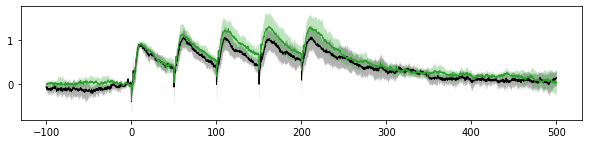

In [11]:
data = np.load('../data/L23-L23-pairs-data-summary.npy', allow_pickle=True).item()

fig, ax = ge.figure(figsize=(3,2.5))
    
ge.plot(data['t'], np.mean(data['freeZinc'], axis=0), sy=data['freeZinc'].std(axis=0),
        color='k', no_set=True, ax=ax)
ge.plot(data['t'], np.mean(data['chelatedZinc'], axis=0), sy=data['chelatedZinc'].std(axis=0),
        color=ge.green, no_set=True, ax=ax);

# Running pair simulations with varying $\alpha_{Zn}$ for the minimization

In [12]:
# execute
# %run pair_calib.py run

# Loading simulation data

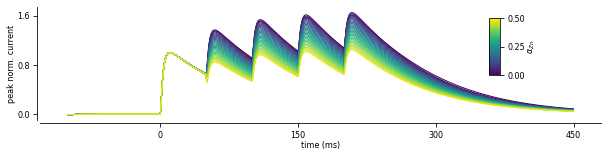

In [74]:
def normalize_model_trace(t, trace, 
                          with_peak_normalization=True,
                          bsl_time = 100, window_for_peak=[100,140]):
    baseline_cond = (t<bsl_time)
    Itrace = -(trace-trace[baseline_cond].mean())
    peak_cond = (t>=window_for_peak[0]) & (t<=window_for_peak[1])
    if with_peak_normalization:
        peak = np.max(Itrace[peak_cond])
    else:
        peak=1
    return 1e3*peak, Itrace/peak


SimData = np.load('../data/pair_calib.npy', allow_pickle=True).item()

tdiscard=100
tend=1000
cond = (SimData['t']>tdiscard) & (SimData['t']<tend)
t = SimData['t'][cond]-tdiscard
integral_condition = (t>100) & (t<450)

fig, ax = ge.figure(figsize=(3,2.5))

Integral = 0.*SimData['alphaZn']
for i in range(len(SimData['alphaZn'])):
    peak_value, trace = normalize_model_trace(t, np.array(SimData['Current'][i]).mean(axis=0)[cond])
    ge.plot(t-100, trace, color=ge.viridis(i/len(SimData['alphaZn'])), ax=ax, no_set=True)
    Integral[i] = np.trapz(trace[integral_condition], t[integral_condition])
    
ge.set_plot(ax, ylabel='peak norm. current', xlabel='time (ms)', num_xticks=5)
Min, Max = SimData['alphaZn'].min(), SimData['alphaZn'].max()
ge.bar_legend(ax,
              inset = {'rect':[.8,.4,.02,.5]},
              label='$\\alpha_{Zn}$',
              bounds=[Min, Max], 
              ticks=[Min, (Max-Min)/2., Max],
              ticks_labels=['%.2f' %x for x in [Min, (Max-Min)/2., Max]],
              colormap=ge.viridis)

# Performing minimization

0.46551724137931033


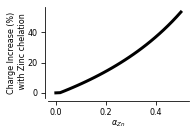

In [75]:
EXP_value = 1.47

fig, ax = ge.figure(figsize=(1.5,2))
ge.plot(SimData['alphaZn'], (Integral[0]/Integral-1)*100, ax=ax, lw=3)
ge.set_plot(ax, xlabel='$\\alpha_{Zn}$', ylabel='Charge Increase (%)\n with Zinc chelation')

i0 = np.argmin((Integral[0]/Integral-EXP_value)**2)
print(SimData['alphaZn'][i0])

->  Best fit found for  0.22413793103448276


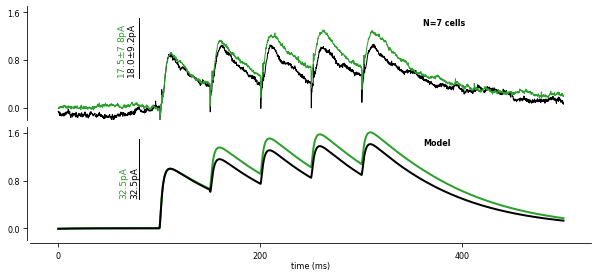

In [25]:
### MODEL
SimData = np.load('../data/pair_calib.npy', allow_pickle=True).item()

tdiscard=100
cond0 = (SimData['t']>tdiscard)
t = SimData['t'][cond]-tdiscard
dt_model = t[1]-t[0]
# chelated
peak_model, modelChelated = normalize_model_trace(t, np.array(SimData['Current'][0]).mean(axis=0)[cond])

### EXPERIMENTAL DATA
data = np.load('../data/L23-L23-pairs-data-summary.npy', allow_pickle=True).item()
dt_exp = data['t'][1]-data['t'][0]
expChelated, expFree = data['chelatedZinc'].mean(axis=0), data['freeZinc'].mean(axis=0)

### INSURE THE SAME TEMPORAL SAMPLING
tmax = min([t[-1], data['t'][-1]])
t_model = t[t<=tmax]
t_exp = data['t'][data['t']<=tmax][::int(np.round(dt_model/dt_exp))]+100
t_model = t_model[:min([len(t_model), len(t_exp)])]
t_exp = t_exp[:min([len(t_model), len(t_exp)])]
expChelated =  expChelated[::int(np.round(dt_model/dt_exp))][:len(t_exp)]
expFree =expFree[::int(np.round(dt_model/dt_exp))][:len(t_exp)]
expEffect = expChelated-expFree
modelChelated = modelChelated[:len(t_model)]

fitWindow = (t_exp>100) & (t_exp<350) # focusing on the Zinc effect window

residual = np.zeros(len(SimData['alphaZn'])-1)

for i in range(1, len(SimData['alphaZn'])): # 0 is chelated-case
    
    _, modelFree = normalize_model_trace(t, np.array(SimData['Current'][i]).mean(axis=0)[cond0])
    modelFree = modelFree[:len(t_model)]
    modelEffect = modelChelated-modelFree
    residual[i-1] = np.sum((expEffect[fitWindow]-modelEffect[fitWindow])**2)
    
# getting the best fit
ibest = 1+np.argmin(residual)
print('->  Best fit found for ', SimData['alphaZn'][ibest])
_, modelFree = normalize_model_trace(t, np.array(SimData['Current'][ibest]).mean(axis=0)[cond])
modelFree = modelFree[:len(t_model)]

### PLOTTING
fig, [ax1,ax2] = ge.figure(axes=(1,2), figsize=(3,2.5), hspace=0.1)
    
ge.plot(t_exp, expFree,  color='k', no_set=True, ax=ax1,
        sy=0*data['freeZinc'].std(axis=0)[::int(np.round(dt_model/dt_exp))][:len(t_exp)])
ge.plot(t_exp, expChelated,  color=ge.green, no_set=True, ax=ax1,
        sy=0*data['chelatedZinc'].std(axis=0)[::int(np.round(dt_model/dt_exp))][:len(t_exp)])
ge.plot(t_model, modelChelated, color=ge.green, no_set=True, ax=ax2, lw=2)
ge.plot(t_model, modelFree, color='k', no_set=True, ax=ax2, lw=2);

ge.annotate(ax1, '%.1f$\pm$%.1fpA' % (np.mean(data['FreeZinc_peaks']),np.std(data['FreeZinc_peaks'])),
                (80,.5), color='k', ha='right', xycoords='data', rotation=90 ,size='large')
ge.annotate(ax1, '%.1f$\pm$%.1fpA\n' % (np.mean(data['ChelatedZinc_peaks']),np.std(data['ChelatedZinc_peaks'])),
                (80,.5), color=ge.green, ha='right', xycoords='data', rotation=90 ,size='large')
ge.annotate(ax1, 'N=%i cells' % len(L23L23_PAIRS_DATASET), (0.7, .9), va='top', bold=True)
    
ge.annotate(ax2, '%.1fpA' % peak_model,
                (80,.5), color='k', ha='right', xycoords='data', rotation=90 ,size='large')
ge.annotate(ax2, '%.1fpA\n' % peak_model,
                (80,.5), color=ge.green, ha='right', xycoords='data', rotation=90 ,size='large')
ax1.plot(80+np.zeros(2), [.5,1.5], 'k-', lw=1)
ax2.plot(80+np.zeros(2), [.5,1.5], 'k-', lw=1)
ge.annotate(ax2, 'Model', (0.7, .9), va='top', bold=True)
    
YLIM = [-0.2,1.7]
ge.set_plot(ax1, ['left'], ylim=YLIM)
ge.set_plot(ax2, ylim=YLIM, xlabel='time (ms)')

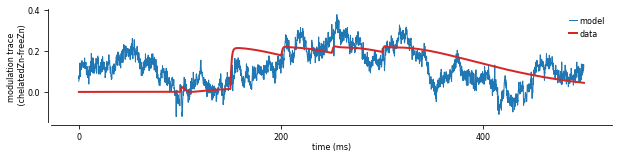

In [39]:
fig, ax = ge.figure(figsize=(3,2.5))   
ge.plot(t_exp, expChelated-expFree,  color=ge.blue, no_set=True, ax=ax, label='model')
ge.plot(t_model, modelChelated-modelFree,  color=ge.red, no_set=True, ax=ax, label='data', lw=2)
ge.legend(ax)
ge.set_plot(ax, ylabel='modulation trace \n (chelatedZn-freeZn)', xlabel='time (ms)')